# Q3 -  RNN (LSTM) for Document Classification

## 3.1 Run the example

In [1]:
from __future__ import division, print_function, absolute_import

import tflearn
from tflearn.data_utils import to_categorical, pad_sequences


In [2]:
from tflearn.datasets import imdb

# IMDB Dataset loading
train, test, _ = imdb.load_data(path='imdb.pkl', n_words=10000,
                                valid_portion=0.1)
trainX, trainY = train
testX, testY = test

# Data preprocessing
# Sequence padding
trainX = pad_sequences(trainX, maxlen=100, value=0.)
testX = pad_sequences(testX, maxlen=100, value=0.)
# Converting labels to binary vectors
trainY = to_categorical(trainY, nb_classes=2)
testY = to_categorical(testY, nb_classes=2)

In [3]:
import tensorflow as tf
# tf reseting
tf.reset_default_graph()

# Network building
net = tflearn.input_data([None, 100])
net = tflearn.embedding(net, input_dim=10000, output_dim=128)
net = tflearn.lstm(net, 128, dropout=0.8)
net = tflearn.fully_connected(net, 2, activation='softmax')
net = tflearn.regression(net, optimizer='adam', learning_rate=0.001,
                         loss='categorical_crossentropy')

# Training
model = tflearn.DNN(net, tensorboard_verbose=0)
model.fit(trainX, trainY, validation_set=(testX, testY), show_metric=True,
batch_size=32)

Training Step: 7040  | total loss: 0.08254
| Adam | epoch: 010 | loss: 0.08254 - acc: 0.9837 | val_loss: 0.76012 - val_acc: 0.8088 -- iter: 22500/22500
Training Step: 7040  | total loss: 0.08254
| Adam | epoch: 010 | loss: 0.08254 - acc: 0.9837 | val_loss: 0.76012 - val_acc: 0.8088 -- iter: 22500/22500
--


## 3.2 MLP Baseline

In [1]:
from __future__ import division, print_function, absolute_import

import tflearn
from tflearn.data_utils import to_categorical, pad_sequences
from tflearn.datasets import imdb
import tensorflow as tf

In [2]:
n_words = 10000

# IMDB Dataset loading
train, test, _ = imdb.load_data(path='imdb.pkl', n_words=n_words,
                                valid_portion=0.1)
trainX, trainY = train
testX, testY = test

We'll now convert our X vectors to sentences of one-hot words, for the classifier to work without further embedding. Labels will be adjusted as before. 

In [3]:
def sent2vec(sent):
    vec = [0] * n_words
    for idx in sent:
        vec[idx] += 1
    return vec

# Converting sentence vectors to word count vectors
trainX_feat = [sent2vec(sent) for sent in trainX]
testX_feat = [sent2vec(sent) for sent in testX]

# Converting labels to binary vectors
trainY_cat = to_categorical(trainY, nb_classes=2)
testY_cat = to_categorical(testY, nb_classes=2)

In [4]:
# tf reseting
tf.reset_default_graph()

# Network building
net2 = tflearn.input_data([None, n_words])
net2 = tflearn.fully_connected(net2, 512, activation='relu')
net2 = tflearn.dropout(net2, 0.5)
net2 = tflearn.fully_connected(net2, 2, activation='softmax')
net2 = tflearn.regression(net2, optimizer='adam', learning_rate=0.001,
                         loss='categorical_crossentropy')

In [5]:
# Training
model2 = tflearn.DNN(net2, tensorboard_verbose=0)
model2.fit(trainX_feat, trainY_cat, validation_set=(testX_feat, testY_cat), show_metric=True,
batch_size=32)

Training Step: 7040  | total loss: 0.10952
| Adam | epoch: 010 | loss: 0.10952 - acc: 0.9758 | val_loss: 0.50196 - val_acc: 0.8844 -- iter: 22500/22500
Training Step: 7040  | total loss: 0.10952
| Adam | epoch: 010 | loss: 0.10952 - acc: 0.9758 | val_loss: 0.50196 - val_acc: 0.8844 -- iter: 22500/22500
--


## 3.3

### 3.3.1 encode_doc(string) & decode_doc(ids)

In [14]:
from reuters import load_data, get_word_index


(X_train, y_train), (X_test, y_test) = load_data()
data = get_word_index()

In [15]:
from nltk import word_tokenize
inv_data = {value: key for key, value in data.items()}

def encode_doc(string):
    return [data[word] for word in word_tokenize(string) if word in data]

def decode_doc(ids):
    return [inv_data[i] for i in ids if i in inv_data]

### 3.3.2 TFLearn version on the Reuters dataset

In [8]:
# Data preprocessing
# Sequence padding
label_num = max(y_train) + 1
X_train = pad_sequences(X_train, maxlen=100, value=0.)
X_test = pad_sequences(X_test, maxlen=100, value=0.)
# Converting labels to binary vectors
y_train = to_categorical(y_train, nb_classes=label_num)
y_test = to_categorical(y_test, nb_classes=label_num)

In [13]:
# TensorFlow resseting
import tensorflow as tf
tf.reset_default_graph()

# Network building
net3 = tflearn.input_data([None, 100])
net3 = tflearn.embedding(net3, input_dim=len(data) + 1, output_dim=128)
net3 = tflearn.lstm(net3, 128, dropout=0.8)
net3 = tflearn.fully_connected(net3, label_num, activation='softmax')
net3 = tflearn.regression(net3, optimizer='adam', learning_rate=0.001,
                         loss='categorical_crossentropy')


In [14]:
# Training
model3 = tflearn.DNN(net3, tensorboard_verbose=0)
model3.fit(X_train, y_train, validation_set=(X_test, y_test), show_metric=True,
batch_size=32)

Training Step: 2810  | total loss: 0.80846
| Adam | epoch: 010 | loss: 0.80846 - acc: 0.8031 | val_loss: 1.50635 - val_acc: 0.6523 -- iter: 8982/8982
Training Step: 2810  | total loss: 0.80846
| Adam | epoch: 010 | loss: 0.80846 - acc: 0.8031 | val_loss: 1.50635 - val_acc: 0.6523 -- iter: 8982/8982
--


### 3.3.3a classify_doc(string)

In [3]:
def classify_doc(string):
    encoded_doc = encode_doc(string)
    padded_doc = pad_sequences([encoded_doc], maxlen=100, value=0.)
    return model3.predict(padded_doc)

### 3.3.3b Explore the Reuters dataset

Explore the Reuters dataset: report on number of classes, number of docs per class, size of docs (number of words per doc) - use Pandas. 

In [4]:
from reuters import load_data, get_word_index
import pandas as pd
from pandas import DataFrame


(X, y), (_,_) = load_data(test_split=0.0)
data = get_word_index()

doc_lengths = [len(x) for x in X]
df = DataFrame(list(zip(doc_lengths, y)), columns=["length", "category"])
df_by_cat = df.groupby("category")
df_by_cat.size()

Using TensorFlow backend.


category
0       67
1      537
2       94
3     3972
4     2423
5       22
6       62
7       19
8      177
9      126
10     154
11     473
12      62
13     209
14      28
15      29
16     543
17      51
18      86
19     682
20     339
21     127
22      22
23      53
24      81
25     123
26      32
27      19
28      58
29      23
30      57
31      52
32      42
33      16
34      57
35      16
36      60
37      21
38      22
39      29
40      46
41      38
42      16
43      27
44      17
45      19
dtype: int64

Thus, there are 46 categories. The size of docs:

In [5]:
df

,length,category
0,87,3
1,56,4
2,139,3
3,224,4
4,101,4
5,116,4
6,100,4
7,100,3
8,82,3
9,106,16


Or, in a more informative fashion:

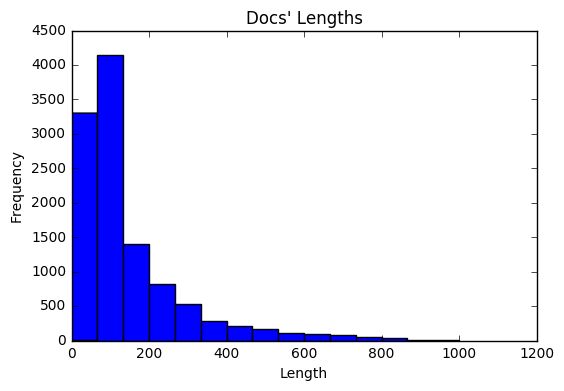

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(df["length"], bins=15, range=(0, 1000))
plt.title("Docs' Lengths")
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.show()

### 3.3.4 Pre-trained word2vec embeddings

In [49]:
# TensorFlow resseting
import tensorflow as tf
import tflearn
from reuters import load_data, get_word_index
from gensim.models import Word2Vec
import numpy as np
from tflearn.data_utils import to_categorical, pad_sequences

(X_train, y_train), (X_test,y_test) = load_data()
data = get_word_index()

In [50]:
class MySentences(object):
    def __init__(self, coded_sents):
        self.coded_sents = coded_sents
 
    def __iter__(self):
        for coded_sent in self.coded_sents:
            yield decode_doc(coded_sent)

Train the Word2Vec model according to our dataset:

In [51]:
all_sents = MySentences(X_train + X_test)
w2v_model = Word2Vec(all_sents, workers=4)

Prepare weights matrix

In [52]:
embedding_matrix = np.random.rand(len(data) + 1, 100)
for word, idx in data.items():
    vec = np.random.rand(100)
    if word in w2v_model:
        vec = w2v_model[word]
    embedding_matrix[idx] = vec

In [53]:
# Sequence padding
X_train_padded = pad_sequences(X_train, maxlen=100, value=0.)
X_test_padded = pad_sequences(X_test, maxlen=100, value=0.)
# Converting labels to binary vectors
y_train_cat = to_categorical(y_train, nb_classes=46)
y_test_cat = to_categorical(y_test, nb_classes=46)

In [54]:
# TensorFlow resseting
tf.reset_default_graph()

# Network building
net4 = tflearn.input_data([None, 100])
net4 = tflearn.embedding(net4, input_dim=len(data)+1, output_dim=100, trainable=False, name="EmbeddingLayer")
net4 = tflearn.lstm(net4, 128, dropout=0.8)
net4 = tflearn.fully_connected(net4, 46, activation='softmax')
net4 = tflearn.regression(net4, optimizer='adam', learning_rate=0.001,
                         loss='categorical_crossentropy')

model4 = tflearn.DNN(net4, tensorboard_verbose=0)

# Retrieve embedding layer weights (only a single weight matrix, so index is 0)
embeddingWeights = tflearn.get_layer_variables_by_name('EmbeddingLayer')[0]
# Assign your own weights (for example, a numpy array [input_dim, output_dim])
model4.set_weights(embeddingWeights, embedding_matrix)


In [55]:
# Training
model4.fit(X_train_padded, y_train_cat, validation_set=(X_test_padded, y_test_cat), show_metric=True,
batch_size=32)

Training Step: 2810  | total loss: 0.95048
| Adam | epoch: 010 | loss: 0.95048 - acc: 0.7472 | val_loss: 1.08895 - val_acc: 0.7226 -- iter: 8982/8982
Training Step: 2810  | total loss: 0.95048
| Adam | epoch: 010 | loss: 0.95048 - acc: 0.7472 | val_loss: 1.08895 - val_acc: 0.7226 -- iter: 8982/8982
--
